In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Input, Reshape, Cropping2D, ZeroPadding2D
from keras.layers.core import Activation, Flatten
from keras.layers.convolutional import UpSampling2D, Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical

Using Theano backend.
Mapped name None to device opencl0:2: AMD Radeon Pro 560 Compute Engine 


In [3]:
Z_DIMS = 16
MAP_TILES = 11
MAP_WIDTH = 28
MAP_HEIGHT = 14

In [4]:
def make_generator_model():
    model = Sequential()
    
    model.add(Dense(256, input_shape=(Z_DIMS,), activation='relu'))
    model.add(Reshape((1,2,128)))
    model.add(UpSampling2D())
    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(UpSampling2D())
    model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
    model.add(UpSampling2D())
    model.add(Conv2D(16,(3,3),padding='same',activation='relu'))
    model.add(UpSampling2D())
    model.add(Conv2D(8,(3,3),padding='same',activation='relu'))
    model.add(Dense(MAP_TILES,activation='softmax'))
    model.add(Cropping2D(((0,16-MAP_HEIGHT),(0,32-MAP_WIDTH))))
    
    return model

In [5]:
def make_discriminator_model():
    model = Sequential()
    
    model.add(ZeroPadding2D(((0,16-MAP_HEIGHT),(0,32-MAP_WIDTH)),input_shape=(MAP_HEIGHT,MAP_WIDTH,MAP_TILES)))
    model.add(Dense(8))
    model.add(Conv2D(16,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Reshape((256,)))
    model.add(Dense(Z_DIMS,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    
    return model

In [6]:
def make_generator_containing_discriminator(g, d):
    model = Sequential()
    model.add(g)
    d.trainable = False
    model.add(d)
    return model

In [7]:
def tiles2image(tiles):
    return get_cmap('rainbow')(tiles/MAP_TILES)

def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:]
    image = np.zeros((height*shape[0], width*shape[1],shape[2]), dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = img
    return image

2172

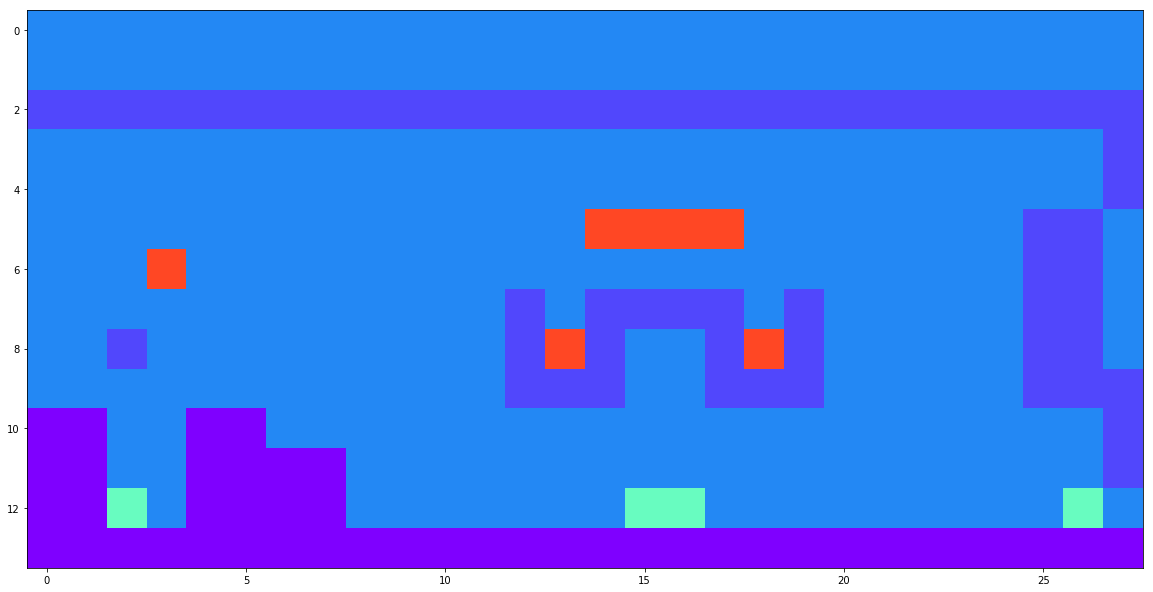

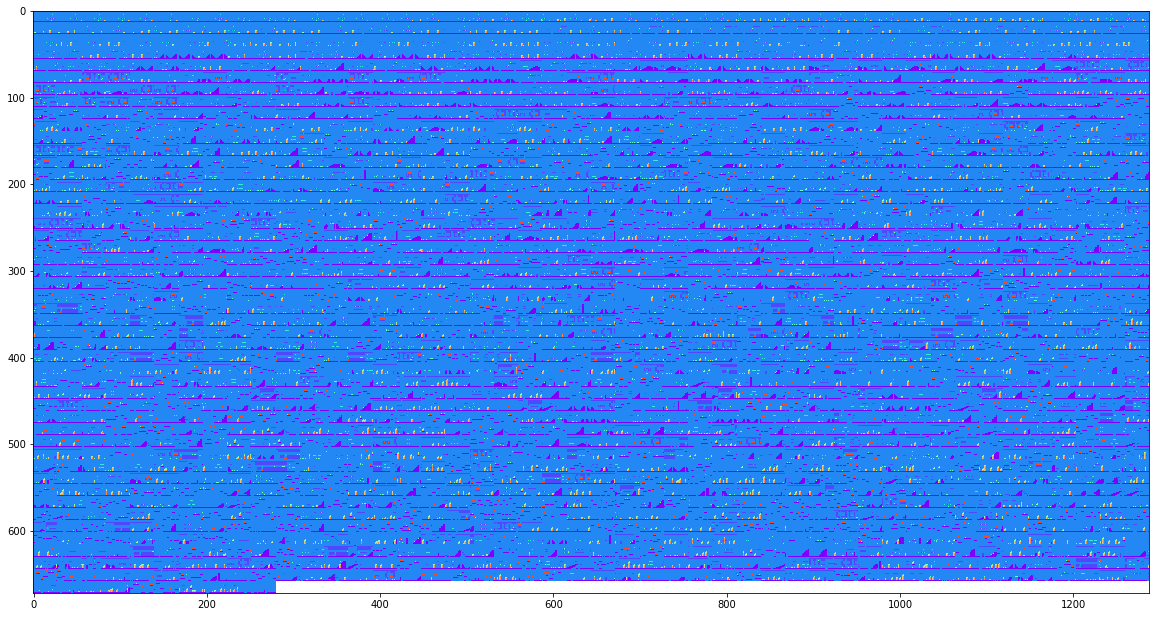

In [8]:
import json
import random

with open("examples.json") as f:
    X_train = array(json.load(f))    

figsize(20,20)
    
imshow(tiles2image(X_train[200]))
figure()
random.shuffle(X_train)
imshow(combine_images(tiles2image(X_train)))
len(X_train)

In [9]:
def train(BATCH_SIZE, X_train):
    
    d = make_discriminator_model()
    g = make_generator_model()
    
    d_on_g = make_generator_containing_discriminator(g, d)
    
    d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    
    g.compile(loss='categorical_crossentropy', optimizer="SGD")
    d_on_g.compile(loss='binary_crossentropy', optimizer=g_optim)
    
    d.trainable = True
    d.compile(loss='binary_crossentropy', optimizer=d_optim)
    
    with open("generator.json","w") as f:
        f.write(g.to_json())
        
    with open("discriminator.json","w") as f:
        f.write(d.to_json())
    
    for epoch in range(1000):
        print("Epoch is", epoch)
        #print("Number of batches", int(X_train.shape[0]/BATCH_SIZE))
        
        for index in range(int(X_train.shape[0]/BATCH_SIZE)):
            
            noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, Z_DIMS))
            true_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            fake_batch = g.predict(noise, verbose=0).argmax(-1)
        
            X = np.concatenate((true_batch, fake_batch))
            y = [1] * len(true_batch) + [0] * len(fake_batch)
            
            X_onehot = to_categorical(X.ravel(), num_classes=MAP_TILES)\
                .reshape((len(X),MAP_HEIGHT,MAP_WIDTH,MAP_TILES))
        
            d_loss = d.train_on_batch(X_onehot, y)
            #print("batch %d d_loss : %f" % (index, d_loss))
            noise = np.random.uniform(-1, 1, (BATCH_SIZE, Z_DIMS))
            d.trainable = False
            g_loss = d_on_g.train_on_batch(noise, [1] * BATCH_SIZE)
            d.trainable = True
            #print("batch %d g_loss : %f" % (index, g_loss))
            print(".",end='')
          
        print("")
        
        sample_batch = g.predict(np.random.uniform(-1, 1, size=(BATCH_SIZE, Z_DIMS)), verbose=0).argmax(-1)
        image = combine_images(tiles2image(sample_batch))
        imsave("sample_"+str(epoch)+".png", image)
        with open("sample_"+str(epoch)+".json","w") as f:
            json.dump(sample_batch.tolist(),f)
        
        g.save_weights('generator.h5', True)
        d.save_weights('discriminator.h5', True)

In [ ]:
!rm sample*.*

In [ ]:
%%time
batch_size = 128
train(batch_size, X_train)

Epoch is 0 Number of batches 16
................
Epoch is 1 Number of batches 16
................
Epoch is 2 Number of batches 16
................
Epoch is 3 Number of batches 16
................
Epoch is 4 Number of batches 16
................
Epoch is 5 Number of batches 16
................
Epoch is 6 Number of batches 16
................
Epoch is 7 Number of batches 16
................
Epoch is 8 Number of batches 16
................
Epoch is 9 Number of batches 16
................
Epoch is 10 Number of batches 16
................
Epoch is 11 Number of batches 16
................
Epoch is 12 Number of batches 16
................
Epoch is 13 Number of batches 16
................
Epoch is 14 Number of batches 16
................
Epoch is 15 Number of batches 16
................
Epoch is 16 Number of batches 16
................
Epoch is 17 Number of batches 16
................
Epoch is 18 Number of batches 16
................
Epoch is 19 Number of batches 16
................
Epoch is 2